##Imports

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
     |████████████████████████████████| 6.6 MB 38.0 MB/s 
     |████████████████████████████████| 596 kB 55.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# The libraries we will use are imported here, in case of runtime problems
import os, shutil  #  file management
import sys 
import requests
import zipfile
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
from tqdm.auto import tqdm # debugging (progress bars)
import sklearn
import copy
import glob
import re
import string
import collections
import json
import torch
from transformers import BertTokenizerFast
import torch.nn as nn
from transformers import BertModel,BertPreTrainedModel
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# typing
from typing import List, Callable, Dict

##Dataset Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.getcwd()

'/content'

In [ ]:
import urllib.request  #  download files
import tarfile  #  unzip files
import csv

dataset_folder = os.path.join(os.getcwd(), "/content/drive/MyDrive/")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

dataset_path = os.path.join(dataset_folder, "training_set.json")

with open(dataset_path, 'r') as json_file:
    json_data = json.load(json_file)

print("Successful extraction")

Successful extraction


##Dataframe creation

In [ ]:
def json_to_dataframe(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path, [['data','title']])
    m = pd.io.json.json_normalize(file, record_path[:-1])
    r = pd.io.json.json_normalize(file, record_path[:-2])

    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values, m.answers.str.len())

    m['context'] = idx
    js['id'] = ndx

    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('id')],1,sort=False).reset_index()
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("dataframe creation done!\n")
    return main

In [ ]:
def add_end_idx():
    """
    Adds the index of the end of answers to the dataframe
    """
    global end
    end = []
    for answer, start, context in zip(df.text, df.answer_start, df.context):
        full_text = answer
        start_idx = start
        end_idx = start_idx + len(full_text)
        
        if context[start_idx:end_idx] == full_text:
            end.append(end_idx)
        elif context[start_idx-1:end_idx-1] == full_text:
            start = start_idx - 1
            end.append(end_idx-1)   
        elif context[start_idx-2:end_idx-2] == full_text:
            start = start_idx - 2
            end.append(end_idx-2)
    df['answer_end'] = end
    print('Answer end index added!')

In [ ]:
input_file_path = dataset_path
record_path = ['data','paragraphs','qas','answers']
df = json_to_dataframe(input_file_path=input_file_path,record_path=record_path)
add_end_idx()

Reading the json file
processing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


shape of the dataframe is (87599, 6)
dataframe creation done!

Answer end index added!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [ ]:
df.head()

,id,question,context,answer_start,text,data.title,answer_end
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,University_of_Notre_Dame,541
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,University_of_Notre_Dame,213
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,University_of_Notre_Dame,296
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,University_of_Notre_Dame,420
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,University_of_Notre_Dame,126


##Text Cleaning

In [ ]:
# text cleaning from evaluate.py for the predicted answers
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

##Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

def split_data():

    global train, val, train_context,val_context,train_questions,val_questions,\
    train_answers,val_answers,train_start_idx,train_end_idx

    gss = GroupShuffleSplit(n_splits=1, train_size=.9, random_state=42)
    for train_idx, test_idx in gss.split(df, groups=df['data.title']):
        train = df.iloc[train_idx]
        val = df.iloc[test_idx]

    train_context = train['context'].values
    val_context = val['context'].values

    train_questions = train['question'].values
    val_questions = val['question'].values

    train_answers = train['text'].values
    val_answers = val['text'].values

    train_start_idx = train['answer_start'].values

    train_end_idx = train['answer_end'].values

    print('Dataset splits statistics: ')
    print('Train data: ', train.shape)
    print('Validation data: ', val.shape)

##Tokenizing

In [ ]:
# initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

##Run splitting

In [ ]:
split_data()

Dataset splits statistics: 
Train data:  (77668, 7)
Validation data:  (9931, 7)


##Data Analysis

In [ ]:
def prepare_analyse(contexts):
    """
    Converts contexts to tokens for plotting
    returns: 
    context_list: list of context tokens
    start_position: list of start positions 
    end_position:
    """
    context_list = []

    start_position = []
    end_position = []

    for i in tqdm(range(len(train_context))):
        encoding = tokenizer(train_context[i])
        token_list = tokenizer.convert_ids_to_tokens(encoding['input_ids'],skip_special_tokens=True)
        context_list.append(['[UNK]']+token_list)

    return context_list

In [ ]:
train_context_list = prepare_analyse(train_context)

  0%|          | 0/77668 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
def inspect_data(listname, name):
  minimum = min(listname)
  maxaimum = max(listname)
  print('Minimum of ' + name + ' is: '+ str(minimum))
  print('Maximum of ' + name + ' is: '+ str(maxaimum))

Minimum of context list is: 26
Maximum of context list is: 854


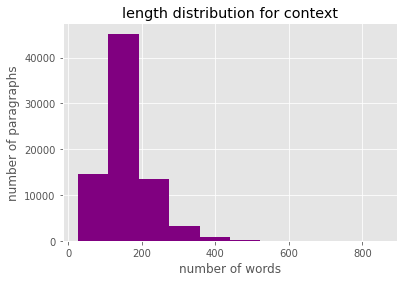

In [ ]:
length_list = []
for i in train_context_list:
    length_list.append(len(i))
inspect_data(length_list, 'context list')
plt.cla()
plt.hist(length_list, color = 'purple')
plt.title('length distribution for context')
plt.ylabel("number of paragraphs")
plt.xlabel("number of words")
plt.show() 

Minimum of answer list is: 1
Maximum of answer list is: 239


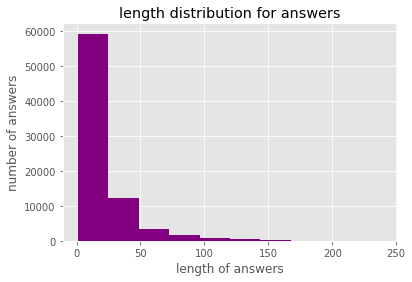

In [ ]:
length_list = []
for i in range(len(train_answers)):
    start = train_start_idx[i]
    end = train_end_idx[i]
    if start==0 and end==0:
        continue
    else:        
        length_list.append(end-start)
inspect_data(length_list, 'answer list')
plt.cla()
plt.hist(length_list, color='purple')
plt.title('length distribution for answers')
plt.ylabel("number of answers")
plt.xlabel("length of answers")
plt.show()

##Train Encoding

In [ ]:
# max sequence length is the 99.4th percentile of context lengths otherwise we ran out of memory
max_length = int(np.quantile([len(seq) for seq in train_context_list], 0.994))
print(max_length)

400


In [ ]:
train_encodings = tokenizer(train_context.tolist(), train_questions.tolist(),\
                            truncation=True, padding='max_length', max_length=max_length)

val_encodings = tokenizer(val_context.tolist(), val_questions.tolist(),\
                          truncation=True, padding='max_length', max_length=max_length)

In [ ]:
def token_positions(encodings, start, end):
    """
    Converts character start/end positions to token start/end positions 
    using thr char_to_token() method.
    """
    start_positions = []
    end_positions = []

    for i in range(len(train_answers)):
        if start[i]==0 and end[i]==0:
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_positions.append(encodings.char_to_token(i, start[i]))
            end_positions.append(encodings.char_to_token(i, end[i] - 1))

            if start_positions[-1] is None:
                start_positions[-1] = max_length-1
            if end_positions[-1] is None:
                end_positions[-1] = max_length-1
            
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [ ]:
token_positions(train_encodings, list(train_start_idx), list(train_end_idx))

##Squad Dataset

Prepare datasets that will be used for training and validation using the torch Dataset class.

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
# validation dataset contains full text of answers because it is needed for
# evaluation
class SquadDataset_Validation(torch.utils.data.Dataset):
    
    def __init__(self, encodings, answers):
        self.encodings = encodings
        self.answers = answers

    def __getitem__(self, idx):
        return_dict = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return_dict['full_text'] = self.answers[idx]
        
        return return_dict

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset_Validation(val_encodings, val_answers)

##Question Answering BERT Class

In [ ]:
class Bert(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        
        self.bert = BertModel(config, add_pooling_layer=False)
        self.fc = nn.Linear(config.hidden_size, 2)
        self.criterion = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids,
        attention_mask,
        token_type_ids,
        start_positions,
        end_positions,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        sequence_output = outputs.last_hidden_state 

        logits = self.fc(sequence_output) 
        
        context_mask = (attention_mask-token_type_ids).unsqueeze(-1) 
        logits = logits + (context_mask + 1e-45).log()

        start_logits, end_logits = logits.split(1, dim=-1) 
        start_logits = start_logits.squeeze(-1) 
        end_logits = end_logits.squeeze(-1) 

        start_loss = self.criterion(start_logits, start_positions)
        end_loss = self.criterion(end_logits, end_positions)
        loss = start_loss + end_loss

        return loss
    
    
    def get_scores(self,
        input_ids,
        attention_mask,
        token_type_ids
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )

        sequence_output = outputs.last_hidden_state

        logits = self.fc(sequence_output) 
        
        context_mask = (attention_mask-token_type_ids).unsqueeze(-1) 
        logits = logits + (context_mask + 1e-45).log()

        start_logits, end_logits = logits.split(1, dim=-1) 
        start_logits = start_logits.squeeze(-1) 
        end_logits = end_logits.squeeze(-1) 

        start_score = nn.Softmax(dim=1)(start_logits)
        end_score = nn.Softmax(dim=1)(end_logits)

        return start_score, end_score

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW

import gc
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

##Evaluation methods

In [ ]:
def compute_exact(a_gold, a_pred):
    if normalize_answer(a_gold) == normalize_answer(a_pred):
        return 1
    else:
        return 0


def compute_f1(a_gold, a_pred):
    gold_tokens = get_tokens(a_gold)
    pred_tokens = get_tokens(a_pred)

    common = collections.Counter(gold_tokens) & collections.Counter(pred_tokens)
    num_same = sum(common.values())
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    if len(gold_tokens) == 0 or len(pred_tokens) == 0:
        if gold_tokens == pred_tokens:
            return 1
        else:
            return 0
    
    if num_same == 0:
        return 0

    precision = 1.0 * num_same / len(pred_tokens)
    recall = 1.0 * num_same / len(gold_tokens)
    f1 = (2.0 * precision * recall) / (precision + recall)
    return f1

In [ ]:
def evaluate(model, dataset):
    # disable gradient calculation
    with torch.no_grad():
        model.eval()
        device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
        model.to(device)

        em = 0.0
        f1 = 0.0

        for i in tqdm(range(len(dataset))):
            temp_data = dataset[i]
            input_ids = temp_data['input_ids'].to(device).unsqueeze(0)
            token_type_ids = temp_data['token_type_ids'].to(device).unsqueeze(0)
            attention_mask = temp_data['attention_mask'].to(device).unsqueeze(0)

            start_score, end_score = model.get_scores(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            
            start_score = start_score.squeeze(0).cpu()
            end_score = end_score.squeeze(0).cpu()

            answer_start = torch.argmax(start_score).item()
            answer_end = torch.argmax(end_score).item()

            pred = ''
            length = start_score.size(0)
            
            if  (answer_start == 0 or answer_end == 0 or answer_start==(length-1) or answer_end==(length-1) ) or  answer_end < answer_start or answer_end - answer_start > 20:
                pred = ''
            else:    
                input_ids.cpu()
                pred = tokenizer.decode(input_ids[0][answer_start:(answer_end+1)])
                
            
            full_text = dataset[i]['full_text']

            em += compute_exact(full_text,pred)
            f1 += compute_f1(full_text,pred)
        
        em /= len(dataset)
        f1 /= len(dataset)

        print('EM: %.5f'%em)
        print('F1: %.5f'%f1)

        return em, f1

##Train

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW

torch.cuda.empty_cache()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = Bert.from_pretrained('bert-base-uncased')

model.to(device)
model.train()

train_dataset = SquadDataset(train_encodings)
train_loader = DataLoader(train_dataset, batch_size=26, shuffle=True, drop_last=True)
optim = AdamW(model.parameters(), lr=3e-5)

iter_counter = 0
best_f1 = 0
avg_loss = 0

for epoch in range(3):
    print('epoch %d start!'%(epoch+1))
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        loss = model(input_ids, attention_mask=attention_mask, start_positions=start_positions,
                     end_positions=end_positions, token_type_ids=token_type_ids)
        loss.backward()
        optim.step()

        iter_counter += 1

        avg_loss += loss.item()
        count = 100
        if iter_counter%count == 0:
            avg_loss /= count
            print('iter %d'%iter_counter)
            print('loss %.5f'%avg_loss)
            avg_loss = 0
            print()
        if iter_counter%2000 == 0 or iter_counter == 8900:
            em,f1 = evaluate(model,val_dataset)

            model.train()
            if f1>best_f1:
                best_f1 = f1
                model.save_pretrained("/content/drive/MyDrive/")
            print()
    print('epoch %d finish!'%(epoch+1))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing Bert: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing Bert from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Bert from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Bert were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

epoch 1 start!
iter 100
loss 6.46724

iter 200
loss 3.77759

iter 300
loss 3.38553

iter 400
loss 3.07492

iter 500
loss 2.96813

iter 600
loss 2.80045

iter 700
loss 2.88903

iter 800
loss 2.69643

iter 900
loss 2.61774

iter 1000
loss 2.54423

iter 1100
loss 2.72213

iter 1200
loss 2.36552

iter 1300
loss 2.55085

iter 1400
loss 2.54904

iter 1500
loss 2.46994

iter 1600
loss 2.39347

iter 1700
loss 2.25343

iter 1800
loss 2.43274

iter 1900
loss 2.50283

iter 2000
loss 2.42567



  0%|          | 0/9931 [00:00<?, ?it/s]

EM: 0.59591
F1: 0.72489

iter 2100
loss 2.50282

iter 2200
loss 2.37394

iter 2300
loss 2.32610

iter 2400
loss 2.32913

iter 2500
loss 2.34033

iter 2600
loss 2.24473

iter 2700
loss 2.25617

iter 2800
loss 2.40899

iter 2900
loss 2.09984

epoch 1 finish!
epoch 2 start!
iter 3000
loss 2.24739

iter 3100
loss 1.65993

iter 3200
loss 1.84538

iter 3300
loss 1.68832

iter 3400
loss 1.66364

iter 3500
loss 1.75207

iter 3600
loss 1.82838

iter 3700
loss 1.59214

iter 3800
loss 1.92061

iter 3900
loss 1.58751

iter 4000
loss 1.73368



  0%|          | 0/9931 [00:00<?, ?it/s]

EM: 0.60961
F1: 0.74023

iter 4100
loss 1.61703

iter 4200
loss 1.62085

iter 4300
loss 1.84126

iter 4400
loss 1.70059

iter 4500
loss 1.64591

iter 4600
loss 1.69772

iter 4700
loss 1.64542

iter 4800
loss 1.65082

iter 4900
loss 1.79120

iter 5000
loss 1.63771

iter 5100
loss 1.54540

iter 5200
loss 1.66268

iter 5300
loss 1.68516

iter 5400
loss 1.73924

iter 5500
loss 1.65855

iter 5600
loss 1.74103

iter 5700
loss 1.72330

iter 5800
loss 1.66667

iter 5900
loss 1.87521

epoch 2 finish!


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_bert = Bert.from_pretrained("/content/drive/MyDrive/", )
model_bert.to(device)
model_bert.eval()
evaluate(model_bert, val_dataset)

  0%|          | 0/9931 [00:00<?, ?it/s]

EM: 0.60961
F1: 0.74023


(0.6096062833551505, 0.7402318040182362)

##Inference

In [1]:
def predict(question, context):
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    with torch.no_grad():
        temp_encoding = tokenizer(context,question,truncation=True,padding=True)
        input_ids = torch.LongTensor(temp_encoding['input_ids']).unsqueeze(0).to(device)
        token_type_ids = torch.LongTensor(temp_encoding['token_type_ids']).unsqueeze(0).to(device)
        attention_mask = torch.LongTensor(temp_encoding['attention_mask']).unsqueeze(0).to(device)

        start_score, end_score = model_bert.get_scores(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        start_score = start_score.squeeze(0).cpu()
        end_score = end_score.squeeze(0).cpu()

        answer_start = torch.argmax(start_score).item()
        answer_end = torch.argmax(end_score).item()

        pred = ''
        length = start_score.size(0)

        if (answer_start == 0 or answer_end == 0 or answer_start==(length-1) or answer_end==(length-1) ) or  answer_end < answer_start or answer_end - answer_start > 20:
                pred = ''
        else:    
            input_ids.cpu()
            pred = tokenizer.decode(input_ids[0][answer_start:(answer_end+1)])

        return pred

In [ ]:
for i in range(10):
    rand_index = np.random.randint(len(val_context))
    context = val_context[rand_index]
    question = val_questions[rand_index]
    p_bert = predict(question,context)
    print('Paragraph:')
    print(context)
    print()
    print('Question:')
    print(question)
    print()
    print('Real Answer: %s'%val_answers[rand_index])
    print('Predicted Answer: %s'%p_bert)
    print()
    print('-'*len(context))
    print()

Paragraph:
Early in the year 343 we find Athanasius had travelled, via Rome, from Alexandria, North Africa, to Gaul; nowadays Belgium / Holland and surrounding areas, where Hosius of Cordoba was Bishop, the great champion of orthodoxy in the West. The two, together, set out for Sardica. A full Council of the Church was convened / summoned there in deference to the Roman pontiff's wishes. The travel was a mammoth task in itself. At this great gathering of prelates, leaders of the Church, the case of Athanasius was taken up once more, that is, Athanasius was formally questioned over misdemeanours and even murder, (a man called Arsenius and using his body for magic, – an absurd charge.). [The Council was convoked for the purpose of inquiring into the charges against Athanasius and other bishops, on account of which they were deposed from their sees by the Semi-Arian Synod of Antioch (341), and went into exile. It was called according to Socrates, (E. H. ii. 20) by the two Emperors, Consta